In [36]:
from smart_open import open
import json
import supermercado
import rasterio as rio
import rioxarray
from rioxarray.merge import merge_arrays
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from utils21 import polygonize_raster_reproj, save_featurecollection, download_tiff, get_ndvi, fetch_tile
import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# Band 4 - Red	0.665	10
# Band 3 - Green	0.560	10
# Band 2 - Blue	0.490	10



In [37]:
geojson_area="data/reforestamos.geojson"
with open(geojson_area, "r", encoding="utf8") as f:
        feature_collection = json.load(f)["features"]
tiles = supermercado.burntiles.burn(feature_collection,14)
tiles

array([[3611, 6987,   14],
       [3612, 6987,   14],
       [3613, 6987,   14],
       [3614, 6987,   14],
       [3611, 6988,   14],
       [3612, 6988,   14],
       [3613, 6988,   14],
       [3614, 6988,   14],
       [3611, 6989,   14],
       [3612, 6989,   14],
       [3613, 6989,   14],
       [3614, 6989,   14]])

In [38]:
tms="https://planetarycomputer.microsoft.com/api/data/v1/mosaic/tiles/217af96b6f5eff81477cf0f155299ec7/{z}/{x}/{y}?scale=2&{assets}&color_formula=Gamma+RGB+3.2+Saturation+0.8+Sigmoidal+RGB+25+0.35&collection=sentinel-2-l2a&format=tif"

In [42]:
def raster_to_1d_(tile_raster):
    print(tile_raster.shape)
    # create an empty array with same dimension and data type
    imgxyb = np.empty((tile_raster.height, tile_raster.width, tile_raster.count), tile_raster.meta['dtype'])
   # loop through the raster's bands to fill the empty array
    for band in range(imgxyb.shape[2]):
        imgxyb[:,:,band] = tile_raster.read(band+1)
    # convert to 1d array
    img1d=imgxyb[:,:,:4].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
    return imgxyb, img1d

In [44]:
images=[]
objs_arrays = {}

for tile in list(tiles)[3:4]:
    x,y,z=tile
    assets="assets=B04&assets=B03&assets=B02"
    url = tms.format(x=x,y=y,z=z, assets=assets)
    path_tile = fetch_tile(tile, url)
    print(path_tile)
    if path_tile is not None:
        tile_raster = rio.open(path_tile)
        imgxyb, img1d = raster_to_1d_(tile_raster)
        print(imgxyb.shape)
        print(img1d.shape)

        
# plt.figure(figsize=[6,6])
# show(images[0], cmap='gray')
# plt.show()


data/3614-6987-14.tif
(512, 512)
(512, 512, 4)
(262144, 4)


# Clustering

In [45]:
cl = cluster.KMeans(n_clusters=5) # create an object of the classifier
param = cl.fit(img1d) # train it
img_cl = cl.labels_ # get the labels of the classes
img_cl = img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


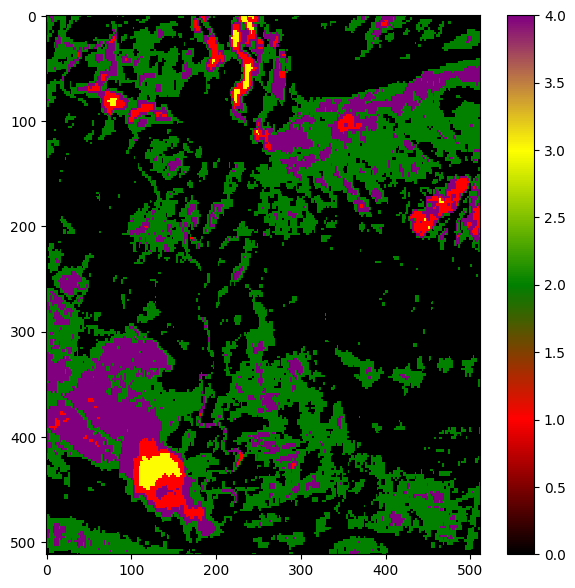

In [46]:
# Create a custom color map to represent our different 4 classes
cmap = LinearSegmentedColormap.from_list("", ["black","red","green","yellow","purple"])
plt.figure(figsize = (7,7))
plt.imshow(img_cl, cmap=cmap, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()


In [47]:
results_ = tiles_array[0]*0 + img_cl

# r = results_.rio.Dataset()
# # help(results_.rio)
# print(type(r))

# results_raster = results_.rio.reproject('epsg:3857')
# results_raster.rio.to_raster("data/resutls_2.tif")

dataset = rio.open("data/resutls_2.tif")
print(type(dataset))



IndexError: list index out of range

# Convert Raster to vector

In [34]:
dataset = rio.open("data/resutls_2.tif")
features = polygonize_raster_reproj(dataset)

features_filter = [f for f in features if f["properties"]["v"] !=0.0]
save_featurecollection( features_filter,'data/results.geojson')
# features_filter



/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


NameError: name 'Polygon' is not defined

# Predictions

In [125]:
# open the raster image
elmanagel = rio.open(‘elmanagel.tif’)
# create an empty array with same dimensions and data type 
elman_xyb = np.empty((elmanagel.height, elmanagel.width,elmanagel.count), elmanagel.meta['dtype'])
# loop through the raster bands and fill the empty array in x-y-bands order
for band in range(elman_xyb.shape[2]):
    elman_xyb[:,:,band] = elmanagel.read(band+1)
# convert to 1d array
elman_1d = elman_xyb[:,:,:3].reshape(elman_xyb.shape[0]*elman_xyb.shape[1], elman_xyb.shape[2])
# predict the clusters in the image 
pred = cl.predict(elman_1d)
# reshape the 1d array predictions to x-y-bands shape order (only one band)
elman_cul = pred
elman_cul = elman_cul.reshape(elman_xyb[:,:,0].shape)

